In [29]:
import os
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
!pip install openpyxl

In [31]:
%reload_ext autoreload
%autoreload 2

In [32]:
pd.options.mode.chained_assignment = None  # prevents warning from slicing popping up if needed: default='warn' :

In [33]:
# path to project: Edit here to point to your Drive
drive = '/content/drive/MyDrive/'
project_dir = 'Colab Notebooks/IronHacks2024_Data_Analytics/DA_Week_3_Project'
COLAB_PROJECT_PATH = drive+project_dir+'/FL Crime Stats - Project'

In [34]:
#Mounted Google Drive: Either on Al or Kat's drive depending where this is
using_colab = False
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)
    using_colab = True

if using_colab and os.path.exists(COLAB_PROJECT_PATH):
    print('found colab path; redirecting to main project directory')
    os.chdir(COLAB_PROJECT_PATH)

Mounted at /content/drive
found colab path; redirecting to main project directory


In [35]:
def read_excel(excel_name:str, header:str='./Generated_Data/'):
  """
  Util function to read excel sheet into dataframe

  Returns: pd.DF - returns dataframe from excel
  """
  excel_path = os.path.join('./Generated_Data/', excel_name+'.xlsx')
  return pd.read_excel(excel_path)

def store_excel(excel_name:str, df, columns=[], read=False):
  """
  Util function to store dataframes into excel files: save our work.
  includes flags to not store if file path doesn't exist, and to return
  dataframe from excel.

  Args:
        excel_name (str) - name of excel file to store data
        df (pd.DF) - the dataframe to save onto excel
        columns(List) - List of columns to only save from df;
                        defaults to empty, whole df is saved
        store (bool) - Flag to store always even if file doesn't exist
        read (bool) - reads dataframe and returns it
  Returns: None| pd.DF - Returns a pd.DF if read is set to True
  """
  data = df
  excel_path = os.path.join('./Generated_Data/', excel_name+'.xlsx')
  if not os.path.exists(excel_path):
    print(f"Creating {excel_path}...")

  if columns:
    data = df[columns]
  data.reset_index(drop=True, inplace=True)
  data.to_excel(excel_path, index=False)

  if read:
    return pd.read_excel(excel_path)


## **2023 Florida Incident Based Reporting System (FIBRS)**

In [36]:
def read_fibrs_files():
  """
  Read the json files for loading cleaning data for fibrs

  Returns : (tuple) - data to use for cleaning fibrs
  """
  files = ('./Object_Files/Fibrs_Replace_Cols.json', './Object_Files/Fibrs_Columns.json')
  replace, cols = None, None
  try:
    with open(files[0],'r') as f1, open(files[1], 'r') as f2:
      replace = f1.read()
      cols = f2.read()
  except IOError as e:
    print("One of the files cannot be loaded! Check Error below.")
    print(f"{e}")

  fibrs_replace = json.loads(replace)
  keep_columns = json.loads(cols)

  return fibrs_replace, keep_columns

In [37]:
# Miami 2023 Statistics
url = "https://www.fdle.state.fl.us/CJAB/UCR/Annual-Reports/FIBRS/FIBRS/Feb-2024/FIBRS_Offense_Detail_2023.aspx"
if os.path.exists('./Data Set - FL Crime/FIBRS_Offense_Detail_2023.xlsx'):
    url = './Data Set - FL Crime/FIBRS_Offense_Detail_2023.xlsx'

stats_2023 = pd.read_excel(url, skiprows=2)
fibrs = stats_2023.copy(deep=True)

stats_2023.head(3)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,County,Agency Name,Unnamed: 2,Quarters Reported,Year to Date,Annual Rate,Year to Date.1,Annual Rate.1,Year to Date.2,Annual Rate.2,...,2023 Q3.35,2023 Q4.35,Year to Date.38,Annual Rate.38,2023 Q1.36,2023 Q2.36,2023 Q3.36,2023 Q4.36,Year to Date.39,Annual Rate.39
0,Alachua,Alachua County Sheriff's Office,127185,4,296,232.7,1094,860.2,2173,1708.5,...,0,0,0,0.0,0,1,2,0,3,2.4
1,Alachua,Gainesville Police Department,147865,4,1130,764.2,4964,3357.1,4264,2883.7,...,0,0,0,0.0,3,2,0,4,9,6.1
2,Alachua,University of Florida Police Department,0,4,12,--,266,--,203,--,...,0,0,0,--,0,0,0,0,0,--


In [38]:
def clean_agg_fibrs(fibrs_df):
  """
  Cleans the fibrs dataset and adds one aggregation:
  the total amount of crimes per agency (per row of data)

  Args: fibrs_df(pd.DataFrame) - the dataframe containing fibrs dataset
  Returns: (pd.Dataframe) - the cleaned/aggregated fibrs dataframe
  """
  # read data for cleaning/ridding columns in fibrs
  fibrs_replace, keep_columns = read_fibrs_files()
  # clean column names
  fibrs_df.rename(columns=lambda x: x.lower().replace(" ", "_"), inplace=True)
  fibrs_df = fibrs_df[keep_columns]
  fibrs_df.rename(columns=fibrs_replace, inplace=True)

  # Clean Agencies values
  replace = {'Police Department':'PD', 'Police Dept.':'PD'}
  fibrs_df['agency_name'].replace(replace, regex=True, inplace=True)
  # aggregate total sum of crimes
  fibrs_df['total_sum_ytd']= fibrs_df.iloc[:,3:40].sum(axis=1)
  return fibrs_df


def get_fibrs_miami_dade(fibrs_df):
  """
  Gets the cleaned fibrs dataframe and its deepcopy containing only rows with
  Miami Dade County and contains the aggregation of
  top crimes listed in each police agency in Miami-Dade

  Args: fibrs_df(pd,DataFrame) - the dataframe containing the fibrs dataset
        NOTE: We pass in the uncleaned/aggregated fibrs_df: will call
              cleaning/aggregation function here

  Returns: tuple[pd.DF, pd.DF] - Cleaned fibrs dataset, Miami-Dade Fibrs dataset
  """
  def find_top_crime(row):
    """Helper function to get top crime per row from crime columns"""
    crime_columns = row.index[3:40]
    max_crime_column = max(crime_columns, key=lambda x: row.loc[x])
    return max_crime_column

  fibrs_clean_agg = clean_agg_fibrs(fibrs_df)
  cond = fibrs_clean_agg['county'] == 'Miami-Dade'
  miami_dade_fibrs = fibrs_clean_agg[cond].copy(deep=True)
  miami_dade_fibrs.reset_index(drop=True, inplace=True)

  miami_dade_fibrs['top_crime'] = miami_dade_fibrs.apply(find_top_crime, axis=1)
  miami_dade_fibrs['top_crime'] = miami_dade_fibrs['top_crime'].str.replace('_ytd','')
  return fibrs_clean_agg , miami_dade_fibrs

In [39]:
fibrs_clean, miami_stats = get_fibrs_miami_dade(fibrs)

store_excel('Fibrs_Miami', miami_stats)
# Create a new DataFrame with agency_name and top_crime columns
updated_stats = store_excel('Fibrs_Miami_Top_Crime', miami_stats, ['agency_name', 'top_crime'], read=True)

In [40]:
fibrs_clean.shape

(118, 41)

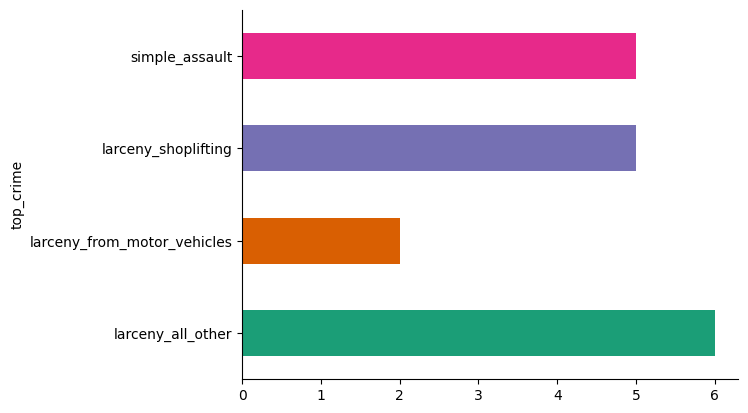

In [41]:
# Assuming updated_stats is your DataFrame
updated_stats.groupby('top_crime').size().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

## **FDLE Criminal History Report: Conviction Data from 2019-2023**


In [48]:
# Concatenate datasets, clean columns and drop unnecessary ones
file_dir = './Data_Set/Florida_Conviction_Data_2019-2023/'
data_files = [os.path.join(file_dir, dataset) for dataset in os.listdir(file_dir)]

def read_fdle_file():
    """
    Reads the json file for fdle for cleaning columns
    Returns: drop(list[str]) - the list of columns to drop in our dataset
    """
    drop_columns = None
    with open('./Object_Files/FDLE_Drop_Columns.json','r') as f:
      drop_columns = f.read()

    drop = json.loads(drop_columns)
    return drop

def clean_fdle(flde_df):
    """
     Cleans the fdle dataset and drops unneeded columns

     Args: fdle_df(pd.DataFrame) - the dataframe containing fdle dataset
     Returns: (pd.Dataframe) - the cleaned dataframe
    """
    flde_df.rename(columns=lambda x: x.lower().replace(" ", "_"), inplace=True)
    flde_df.rename(columns={'age_at_time_of_crime': 'age'}, inplace=True)
    flde_df.rename(columns={'disp_offense': 'crime'}, inplace=True)
    col_drop = read_fdle_file()

    # in case of not all or none in df
    cols_rem_drop = set(col_drop) & set(flde_df.columns)
    if cols_rem_drop:
      flde_df.drop(cols_rem_drop, axis=1, inplace=True)

    return flde_df

files_years = sorted([f'Florida_Conviction_History_{year}' for year in range(2019,2024)])
fl_datasets = []
not_cleaned = False
for exported_file_year, data_file_year in zip(files_years, data_files):
  if not os.path.exists(os.path.join('./Generated_Data', exported_file_year + '.xlsx')):
    fl_datasets.append(pd.read_excel(data_file_year, skiprows=2))
    not_cleaned = True
    store_excel(exported_file_year, clean_fdle(fl_datasets[-1]))
  else:
    fl_datasets.append(read_excel(exported_file_year))

fl_yrs = pd.concat(fl_datasets, ignore_index=True)
fl_yrs = clean_fdle(fl_yrs) if not_cleaned else fl_yrs

In [49]:
fl_yrs.columns

Index(['state', 'county', 'sex', 'race', 'age', 'arrest_date', 'arrest_year',
       'prosecution_date', 'prosecution_year', 'crime', 'disposition_date',
       'disposition_year', 'disposition_final_offense_group', 'final_level',
       'final_degree'],
      dtype='object')

In [50]:
# Data Exploration
print(f"fl_years: {fl_yrs.shape[0]} rows x {fl_yrs.shape[1]} columns" )
print(fl_yrs.isna().any())
num_dups = fl_yrs.duplicated().sum()
if num_dups > 0:
  print(f"number of duplicates: {num_dups}")
  fl_yrs.drop_duplicates(keep="first", inplace=True)
  fl_yrs.reset_index(inplace=True)
  print(f"number of duplicates after dropping: {fl_yrs.duplicated().sum()}")
print(f"fl_years after dropping dups: {fl_yrs.shape[0]} rows x {fl_yrs.shape[1]} columns" )

fl_years: 964216 rows x 15 columns
state                              False
county                             False
sex                                False
race                               False
age                                False
arrest_date                        False
arrest_year                        False
prosecution_date                    True
prosecution_year                    True
crime                              False
disposition_date                   False
disposition_year                   False
disposition_final_offense_group    False
final_level                        False
final_degree                       False
dtype: bool
number of duplicates: 48281
number of duplicates after dropping: 0
fl_years after dropping dups: 915935 rows x 16 columns


In [51]:
print(fl_yrs.dtypes)
fl_yrs.describe(include='object')

index                                       int64
state                                      object
county                                     object
sex                                        object
race                                       object
age                                         int64
arrest_date                        datetime64[ns]
arrest_year                                 int64
prosecution_date                   datetime64[ns]
prosecution_year                          float64
crime                                      object
disposition_date                   datetime64[ns]
disposition_year                            int64
disposition_final_offense_group            object
final_level                                object
final_degree                               object
dtype: object


,state,county,sex,race,crime,disposition_final_offense_group,final_level,final_degree
count,915935,915935,915935,915935,915935,915935,915935,915935
unique,1,67,2,5,225,39,3,8
top,FL,Pinellas County,Male,White,Drug Equip-Possess,Dangerous Drugs,Misdemeanor,1st Degree
freq,915935,69354,730681,588481,88010,223359,570803,412549


In [52]:
pd.set_option('display.max_rows', None)

In [53]:
# top 10 counties by total, top 10 crimes, and top 5 crimes across all counties
lines = '\n' + '-'*35 + '\n'
all_counties = fl_yrs.groupby(['county'])
top_10_counties = all_counties.size().nlargest(10) # print(all_counties["crime"].value_counts().nlargest(10)) <- also gets top 10 counties
print(top_10_counties, end = lines)

all_crimes = fl_yrs.groupby('crime')
top_10_crimes = all_crimes.size().nlargest(10)
print(top_10_crimes, end=lines)

all_years = fl_yrs.groupby('arrest_year').size().nlargest(5)
print(all_years)

county
Pinellas County        69354
Hillsborough County    61324
Duval County           58670
Polk County            54695
Palm Beach County      50748
Volusia County         40294
Brevard County         34089
Escambia County        32765
Broward County         28363
Miami-Dade County      27828
dtype: int64
-----------------------------------
crime
Drug Equip-Possess     88010
Larc                   86373
Moving Traffic Viol    84469
Drugs-Possess          69196
Resist Officer         68181
Trespassing            65598
Battery                61909
Dui-Unlaw Bld Alch     52046
Burgl                  23420
Marijuana-Possess      20902
dtype: int64
-----------------------------------
arrest_year
2019    241045
2021    194411
2020    190752
2022    182476
2023    107251
dtype: int64


In [54]:
pd.set_option('display.max_rows', 20)

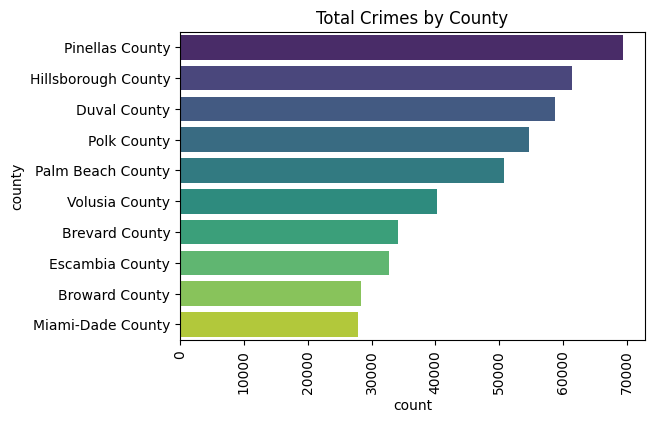

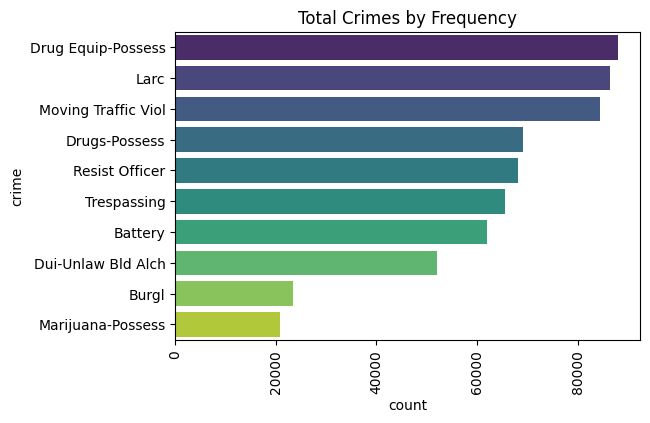

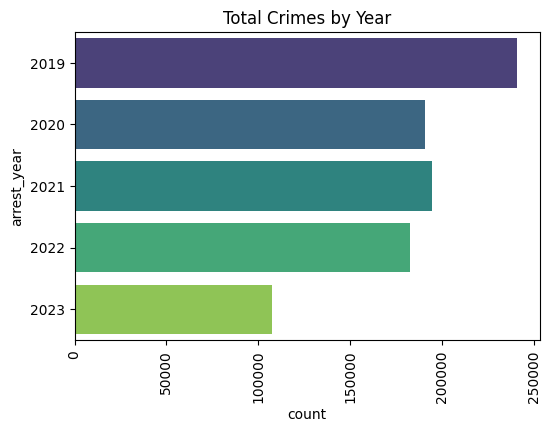

In [55]:
# Get vizs for EDA section
def plot_group_counts(group_series, size_plot, sort=True, descending=False, title_info=None):
  """
  Display the bar plots for each group series

  args: group_series (pd.Series): grouped by data series
        size_plot (tuple[int,int]) - configure size of bar plot figure
        sort (bool) - indicates whether to sort the unpacked series by its group
        descending (boo) - sort in descending order or not if sorting series
        title_info:(None|str) - custom info for title of plot if needed.
  """
  group = group_series.index.name
  group_plot = group_series.reset_index()
  # sort data and get title header
  if sort:
    group_plot.sort_values(group, ascending=(not descending), inplace=True)
  title_header = title_info if title_info != None else group.title()

  group_plot.columns = [group, 'count']
  group_plot[group] = group_plot[group].astype(str)

  plt.figure(figsize=(size_plot[0], size_plot[1]))
  sns.barplot(data=group_plot, y=group, x='count', palette='viridis', hue=group, legend=False)
  plt.title(f'Total Crimes by {title_header}')
  plt.xticks(rotation=90)
  plt.show()

stat_groups = [top_10_counties, top_10_crimes, all_years] # group data series
sort_groups = [False, False, True]                        # sort data flag
group_title_info = [None,"Frequency","Year"]              # info for title
for group_data, to_sort, title_msg in zip(stat_groups,sort_groups, group_title_info):
  plot_group_counts(group_data, size_plot=(6,4), sort=to_sort, title_info=title_msg)

In [56]:
top_10_data = fl_yrs[fl_yrs['county'].isin(top_10_counties.index)]

In [57]:
top_10_crimes = top_10_data[['county', 'arrest_year','crime']]
top_10_crimes.reset_index(drop=True, inplace=True)
top_10_crimes

,county,arrest_year,crime
0,Pinellas County,2019,Dui-Unlaw Bld Alch
1,Palm Beach County,2019,Resist Officer
2,Palm Beach County,2019,Possession Of Weapon
3,Palm Beach County,2019,Cocaine-Possess
4,Palm Beach County,2019,Marijuana-Possess
...,...,...,...
458125,Polk County,2023,Trespassing
458126,Broward County,2023,Larc
458127,Broward County,2023,Larc
458128,Broward County,2023,Trespassing


In [58]:
if not os.path.exists('Generated_Data/Top_10_Convictions_per_year.xlsx'):
  top_crimes_per_year = top_10_crimes.groupby(['county','arrest_year']).apply(lambda x: x['crime'].value_counts().nlargest(1))
else:
  top_10_crimes = read_excel('Top_10_Convictions_per_year')

In [59]:
top_crimes_per_year

county          arrest_year  crime             
Brevard County  2019         Larc                   801
                2020         Larc                   712
                2021         Drug Equip-Possess     961
                2022         Drug Equip-Possess     844
                2023         Larc                   478
                                                   ... 
Volusia County  2019         Trespassing           1113
                2020         Trespassing           1264
                2021         Drug Equip-Possess     928
                2022         Drug Equip-Possess     960
                2023         Drug Equip-Possess     812
Name: count, Length: 50, dtype: int64

In [60]:
#top_10_crimes.drop('Unnamed: 0', axis=1, inplace=True)
top_10_crimes.describe(include='object')

,county,crime
count,458130,458130
unique,10,210
top,Pinellas County,Larc
freq,69354,46261


<Figure size 640x480 with 0 Axes>

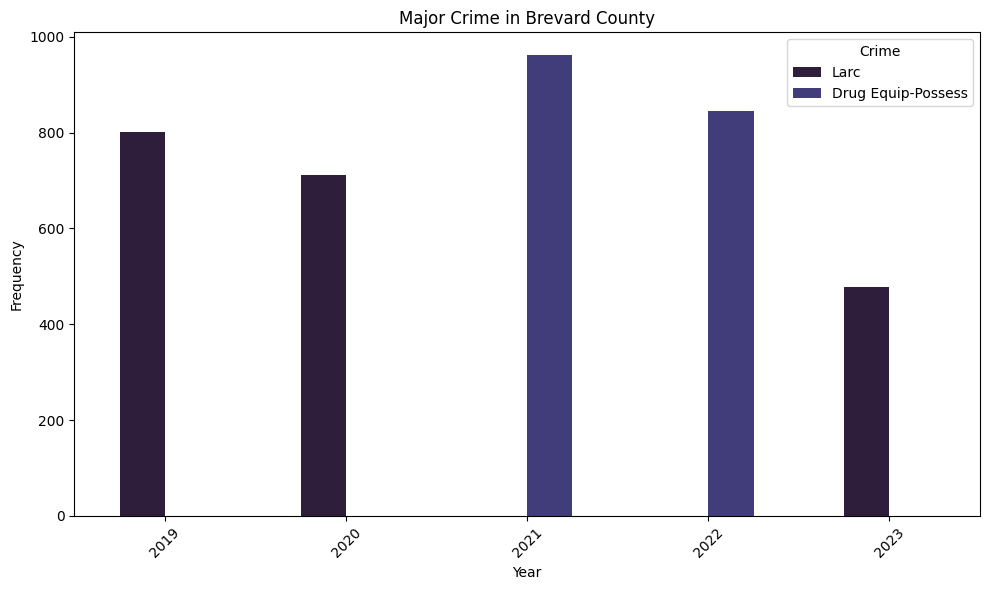

<Figure size 640x480 with 0 Axes>

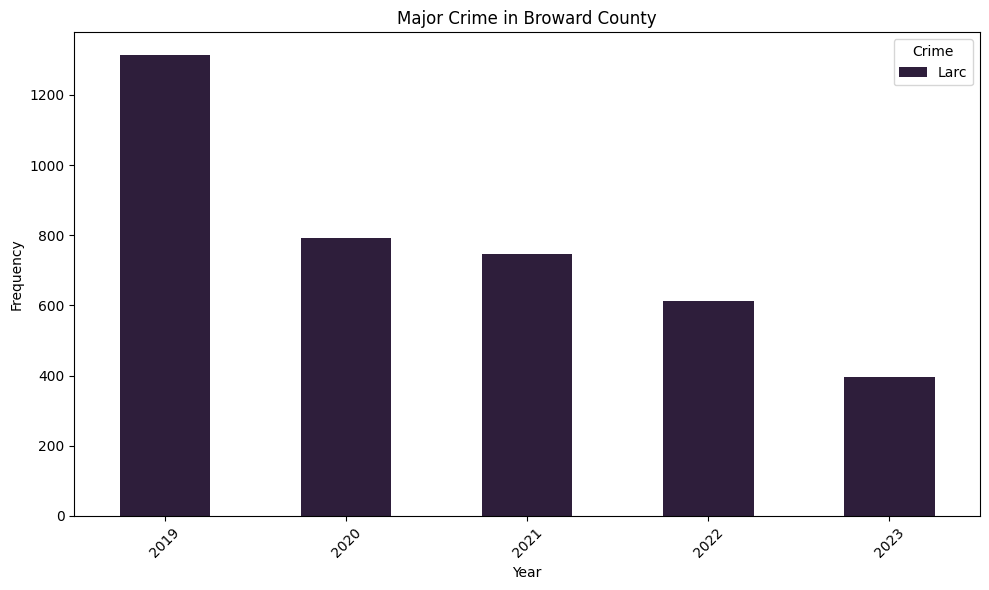

<Figure size 640x480 with 0 Axes>

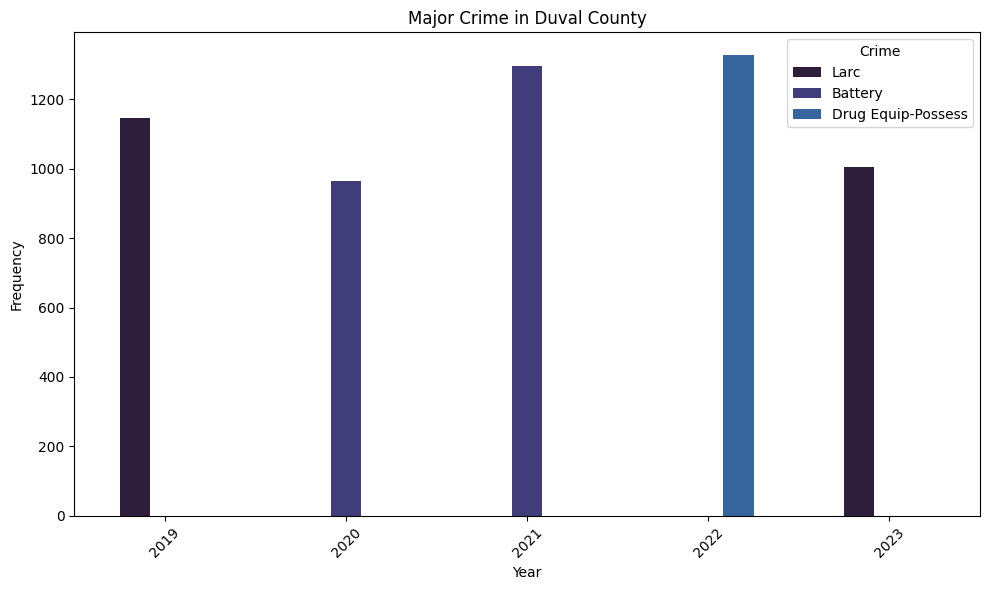

<Figure size 640x480 with 0 Axes>

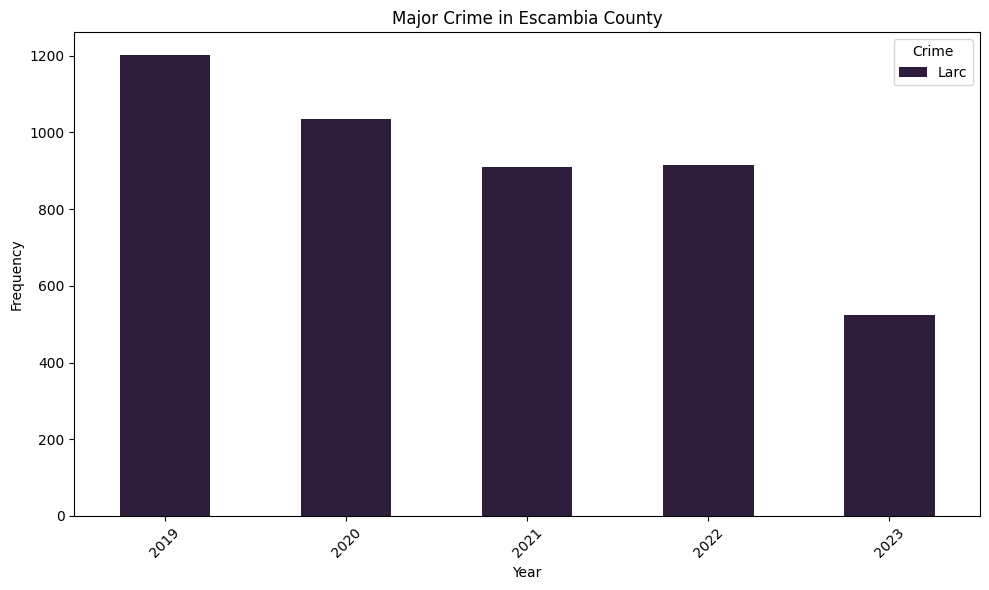

<Figure size 640x480 with 0 Axes>

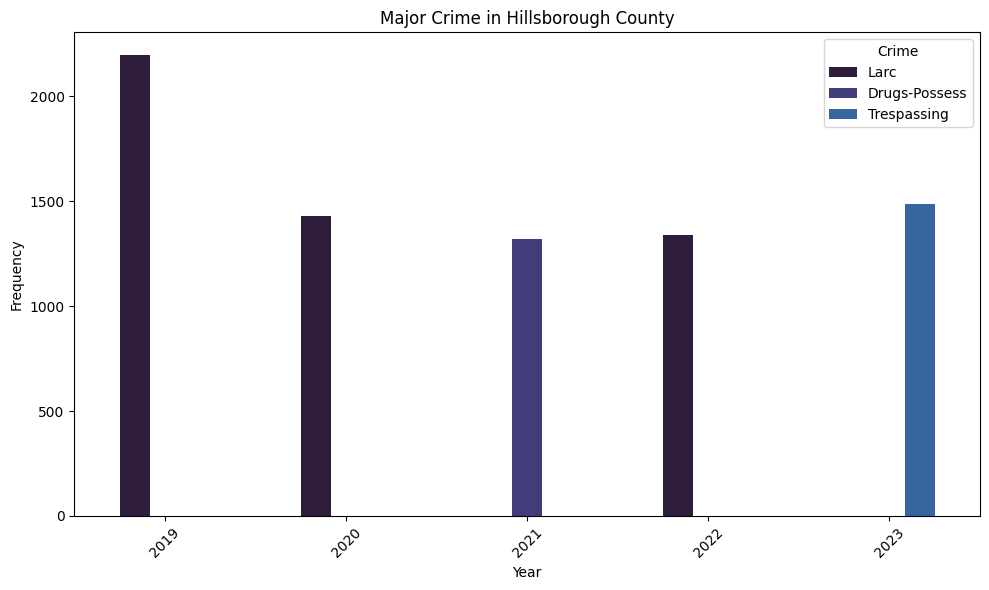

<Figure size 640x480 with 0 Axes>

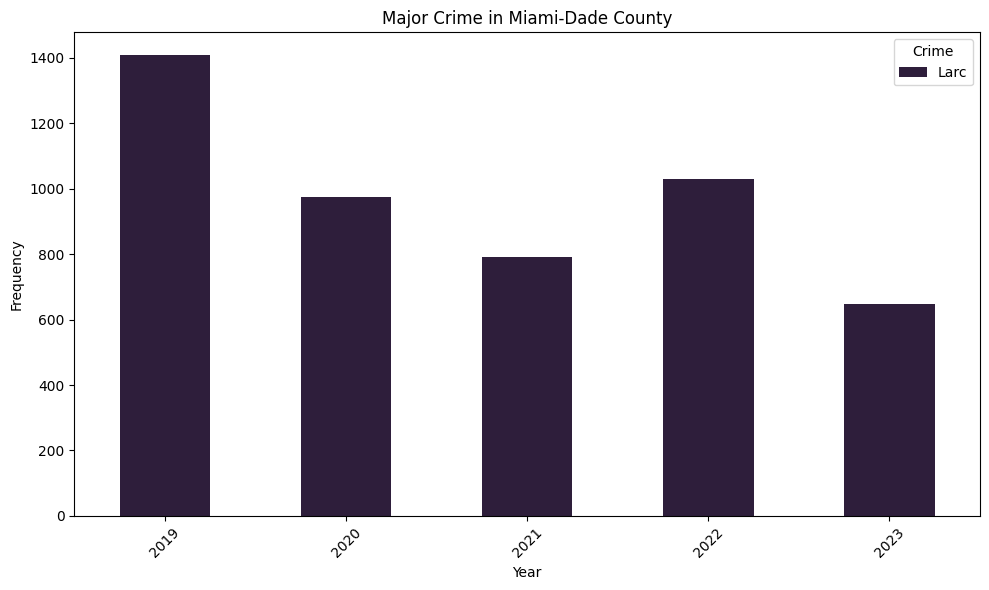

<Figure size 640x480 with 0 Axes>

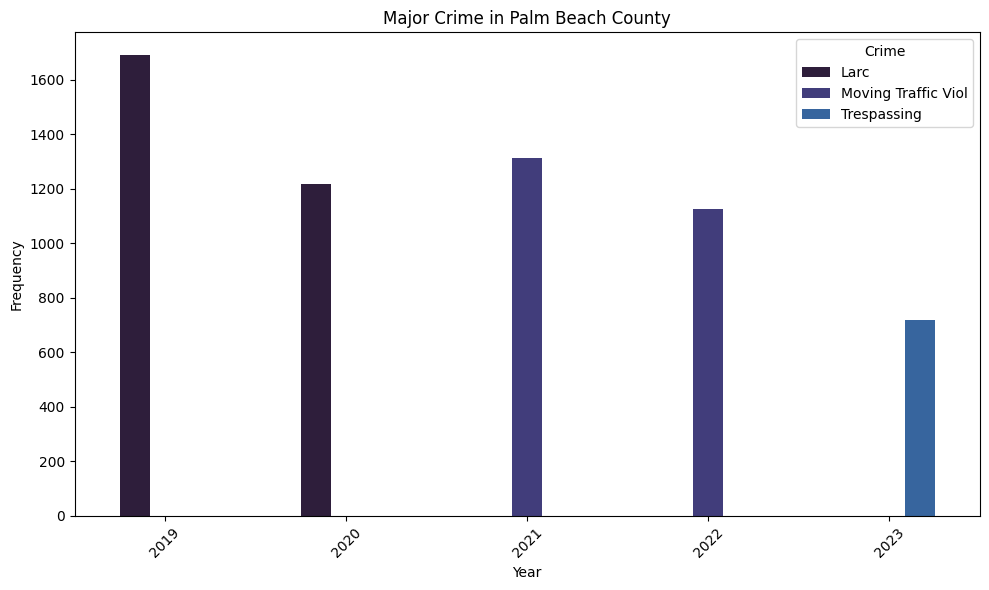

<Figure size 640x480 with 0 Axes>

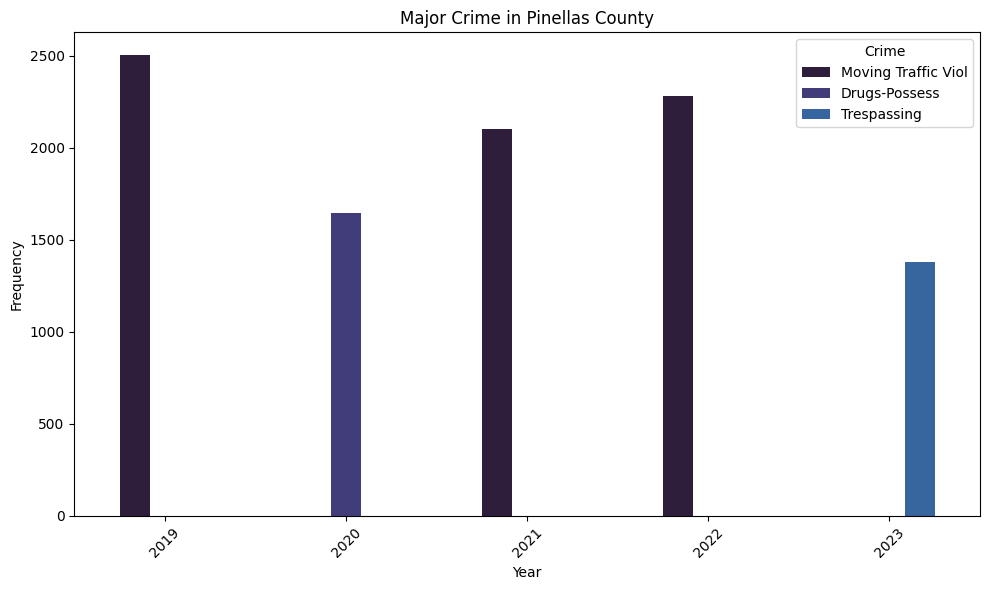

<Figure size 640x480 with 0 Axes>

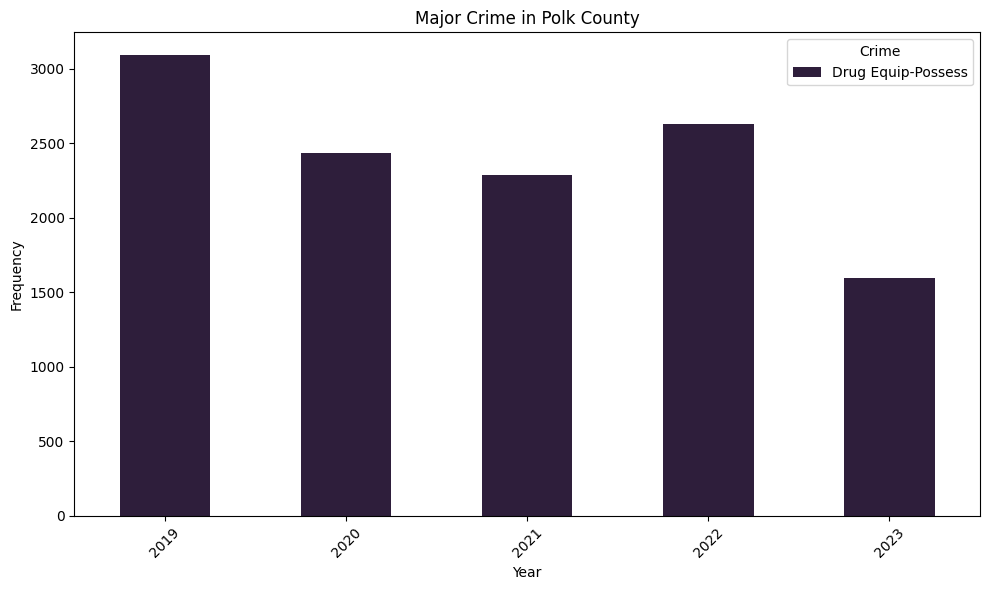

<Figure size 640x480 with 0 Axes>

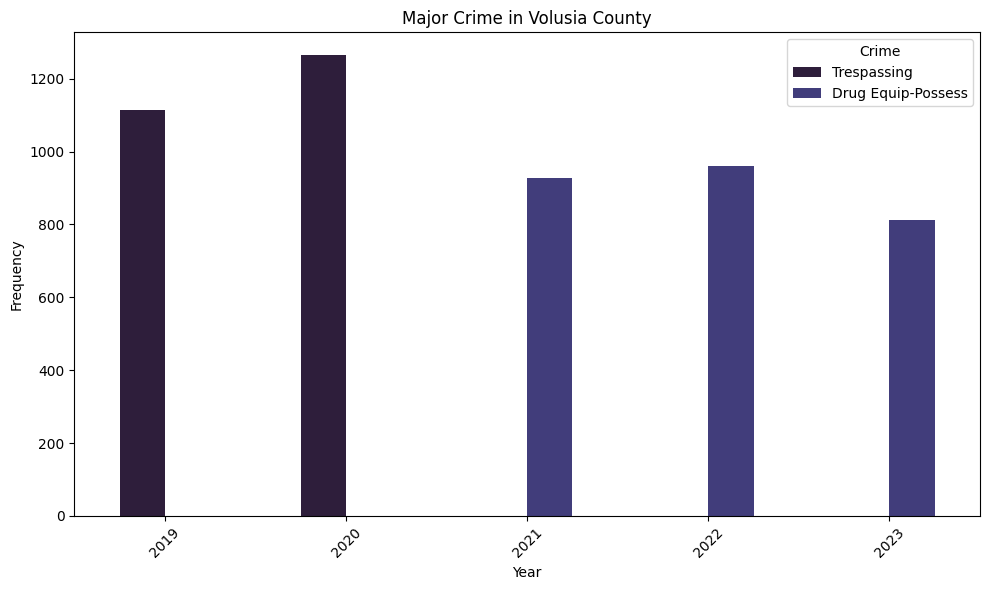

In [61]:
def top_crimes_yearly(include_only=['all']):
  """
  Displays visualization for top crimes for top_crimes_per_year dataframe

  args: include_only (list[str]) - list of strings containing 'all'
        or counties from dataset to only list
  """
  sns.set_palette("mako")
  filter = r'|'.join(include_only)
  for county, data in top_crimes_per_year.groupby(level=0):
      if filter!=r'all' and not re.search(filter, county, re.IGNORECASE):
        continue
      plt.figure()  # Create a new figure for each county
      data.unstack().plot(kind='bar', stacked=False, figsize=(10, 6))  # Plot the data for the current county
      plt.title(f"Major Crime in {county}")  # Set the title for the plot
      plt.xlabel('Year')  # Set the label for the x-axis
      plt.ylabel('Frequency')  # Set the label for the y-axis
      plt.xticks(range(len(data.index.levels[1])), data.index.levels[1], rotation=45)  # Rotate x-axis labels for better readability
      plt.legend(title='Crime')  # Add a legend
      plt.tight_layout()  # Adjust layout to prevent overlap
      plt.show()

top_crimes_yearly(top_10_counties.index)